In [1]:
%matplotlib inline
from __future__ import division, print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

cell_type = "HepG2"
%cd $cell_type

/users/avanti/interpret-benchmark/data/HepG2


In [2]:
!zcat positives_not_in_small_valid_labels.gz | wc -l

12394


### Load positives not seen in training or validation set

In [3]:
import momma_dragonn
from momma_dragonn.data_loaders.pyfasta_data_loader import SingleStreamSeqOnly
import numpy as np
import gzip

fasta_data_source = "/mnt/data/annotations/by_organism/human/hg19.GRCh37/hg19.genome.fa"
positives_data_loader = SingleStreamSeqOnly(batch_size=50, bed_source="positives_not_in_small_valid_labels.gz",
                                  fasta_data_source=fasta_data_source,
                                  rc_augment=False, randomize_after_pass=False, num_to_load_for_eval=None)
positives_data = positives_data_loader.get_data()

Reading bed file positives_not_in_small_valid_labels.gz into memory
Finished reading bed file into memory; got 12394rows


### Load some model

In [4]:
!ls model_files

model_QFbAM_modelJson.json	       record_18_model_u5eMJ_modelWeights.h5
model_QFbAM_modelWeights.h5	       record_19_model_h9WFI_modelJson.json
model_UqOJX_modelJson.json	       record_19_model_h9WFI_modelWeights.h5
model_UqOJX_modelWeights.h5	       record_1_model_v4VYz_modelJson.json
record_10_model_audzA_modelJson.json   record_1_model_v4VYz_modelWeights.h5
record_10_model_audzA_modelWeights.h5  record_2_model_IH83H_modelJson.json
record_11_model_0XKud_modelJson.json   record_2_model_IH83H_modelWeights.h5
record_11_model_0XKud_modelWeights.h5  record_3_model_0FT6i_modelJson.json
record_12_model_rjGet_modelJson.json   record_3_model_0FT6i_modelWeights.h5
record_12_model_rjGet_modelWeights.h5  record_4_model_Dvrnb_modelJson.json
record_13_model_FXPOF_modelJson.json   record_4_model_Dvrnb_modelWeights.h5
record_13_model_FXPOF_modelWeights.h5  record_5_model_1Q9Lp_modelJson.json
record_14_model_g60lE_modelJson.json   record_5_model_1Q9Lp_modelWeights.h5
record_14_model_g60lE_modelWeight

In [5]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc

In [6]:
model_id = "record_1_model_v4VYz"
model_json = "model_files/"+model_id+"_modelJson.json"
model_weights = "model_files/"+model_id+"_modelWeights.h5"
#model_json = "model_files/model_UqOJX_modelJson.json"
#model_weights = "model_files/model_UqOJX_modelWeights.h5"
deeplift_genomicsdefault_model =\
    kc.convert_model_from_saved_files(
        json_file=model_json,
        h5_file=model_weights,
        nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault) 
deeplift_rescale_model =\
    kc.convert_model_from_saved_files(
        json_file=model_json,
        h5_file=model_weights,
        nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Rescale) 

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 2 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 6 the preceding linear layer is 4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 10 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 15 the preceding linear layer is 13 of type Dense;
In accordance with nonlinea

### Sanity check that the model performs reasonably

In [7]:
#valid_data_loader = SingleStreamSeqOnly(batch_size=50, bed_source="small_valid_labels.gz",
#                                  fasta_data_source=fasta_data_source,
#                                  rc_augment=False, randomize_after_pass=False, num_to_load_for_eval=None)
#valid_data = valid_data_loader.get_data()

Do a basic investigation of GC fraction

In [8]:
#mean_neg = np.mean(valid_data.X[valid_data.Y.squeeze()==0],axis=0)
#mean_pos = np.mean(valid_data.X[valid_data.Y.squeeze()==1],axis=0)
#print("Negatives ACGT frac")
#print(np.mean(valid_data.X[valid_data.Y.squeeze()==0],axis=(0,1)))
#print("Positives ACGT frac")
#print(np.mean(valid_data.X[valid_data.Y.squeeze()==1],axis=(0,1)))
#print("for negatives")
#plt.plot(range(1000),mean_neg[:,0]+mean_neg[:,3])
#plt.plot(range(1000),mean_neg[:,1]+mean_neg[:,2])
#plt.show()
#print("for positives")
#plt.plot(range(1000),mean_pos[:,0]+mean_pos[:,3])
#plt.plot(range(1000),mean_pos[:,1]+mean_pos[:,2])
#plt.show()

In [9]:
pred_func = deeplift.util.compile_func(
    inputs=[deeplift_genomicsdefault_model.get_layers()[0].get_activation_vars()],
    outputs=deeplift_genomicsdefault_model.get_layers()[-2].get_activation_vars()[:,0])

In [10]:
#valid_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
#                            input_data_list=[valid_data.X],
#                            batch_size=200,
#                            progress_update=10000))

In [11]:
unseen_positives_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
                            input_data_list=[positives_data.X],
                            batch_size=200,
                            progress_update=10000))

Done 0
Done 10000


Using TensorFlow backend.


In [12]:
#import seaborn as sns
#from sklearn.metrics import roc_auc_score
#print(roc_auc_score(y_true=valid_data.Y.squeeze(), y_score=np.array(valid_preds).squeeze()))
#from matplotlib import pyplot as plt
##histogram the predictions
#sns.distplot(valid_preds[valid_data.Y.squeeze()==0],bins=20)
#sns.distplot(valid_preds[valid_data.Y.squeeze()==1],bins=20)
#sns.distplot(unseen_positives_preds,bins=20)
#plt.show()

### Prepare the deeplift, gradients and integrated gradients scoring functions

Utility functions for dinuc shuffling

In [13]:
from deeplift import dinuc_shuffle

argmax_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
def onehot_to_seq(onehot):
    seq = "".join([argmax_to_letter[x] for x in np.argmax(onehot,axis=-1)])
    return seq

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
positives_seqs = [onehot_to_seq(x) for x in positives_data.X]

Look at prediction with flat references

In [14]:
print("Prediction under all zero input",pred_func([np.zeros((1,1000,4))]))
avgpos_gcref = np.mean(positives_data.X, axis=0, keepdims=True)
print("Prediction under avg pos input", pred_func([avgpos_gcref]))

Prediction under all zero input [-14.88747]
Prediction under avg pos input [116.84889]


Compile the various scoring functions

In [15]:
import tensorflow as tf
grad = tf.gradients(ys=deeplift_genomicsdefault_model.get_layers()[-2].get_activation_vars(),
                    xs=deeplift_genomicsdefault_model.get_layers()[0].get_activation_vars())[0]
unbatched_grad_func = deeplift.util.compile_func(
                        inputs=[deeplift_genomicsdefault_model.get_layers()[0].get_activation_vars()],
                        outputs=grad)

def list_wrapper(func):
    def wrapped_func(input_data_list, **kwargs):
        if (isinstance(input_data_list, list)):
            remove_list_on_return=False
        else:
            remove_list_on_return=True
            input_data_list = [input_data_list]
        to_return = func(input_data_list=input_data_list,
                         **kwargs)
        return to_return
    return wrapped_func

@list_wrapper
def grad_func(input_data_list, input_references_list, task_idx, **kwargs):
    assert len(input_data_list)==1
    to_return = np.array(deeplift.util.run_function_in_batches(
                    unbatched_grad_func,
                    input_data_list=input_data_list,
                    **kwargs))
    return to_return

def empty_ism_buffer(results_arr,
                     input_data_onehot,
                     perturbed_inputs_preds,
                     perturbed_inputs_info):
    for perturbed_input_pred,perturbed_input_info\
        in zip(perturbed_inputs_preds, perturbed_inputs_info):
        example_idx = perturbed_input_info[0]
        if (perturbed_input_info[1]=="original"):
            results_arr[example_idx] +=\
                (perturbed_input_pred*input_data_onehot[example_idx])
        else:
            pos_idx,base_idx = perturbed_input_info[1]
            results_arr[example_idx,pos_idx,base_idx] = perturbed_input_pred

def make_ism_func(prediction_func,
                  flank_around_middle_to_perturb,
                  batch_size=200):
    @list_wrapper
    def ism_func(input_data_list, progress_update=10000, **kwargs):
        assert len(input_data_list)==1
        input_data_onehot=input_data_list[0]
        
        results_arr = np.zeros_like(input_data_onehot).astype("float64")
        
        perturbed_inputs_info = []
        perturbed_onehot_seqs = []
        perturbed_inputs_preds = []
        num_done = 0
        for i,onehot_seq in enumerate(input_data_onehot):
            perturbed_onehot_seqs.append(onehot_seq)
            perturbed_inputs_info.append((i,"original"))
            for pos in range(int(len(onehot_seq)/2)-flank_around_middle_to_perturb,
                             int(len(onehot_seq)/2)+flank_around_middle_to_perturb):
                for base_idx in range(4):
                    if onehot_seq[pos,base_idx]==0:
                        assert len(onehot_seq.shape)==2
                        new_onehot = np.zeros_like(onehot_seq) + onehot_seq
                        new_onehot[pos,:] = 0
                        new_onehot[pos,base_idx] = 1
                        perturbed_onehot_seqs.append(new_onehot)
                        perturbed_inputs_info.append((i,(pos,base_idx)))
                        num_done += 1
                        if ((progress_update is not None)
                            and num_done%progress_update==0):
                            print("Done",num_done)
                        if (len(perturbed_inputs_info)>=batch_size):
                            empty_ism_buffer(
                                 results_arr=results_arr,
                                 input_data_onehot=input_data_onehot,
                                 perturbed_inputs_preds=
                                  prediction_func([perturbed_onehot_seqs]),
                                 perturbed_inputs_info=perturbed_inputs_info)
                            perturbed_inputs_info = []
                            perturbed_onehot_seqs = []
        if (len(perturbed_inputs_info)>0):
            empty_ism_buffer(
                 results_arr=results_arr,
                 input_data_onehot=input_data_onehot,
                 perturbed_inputs_preds=
                  prediction_func([perturbed_onehot_seqs]),
                 perturbed_inputs_info=perturbed_inputs_info)
        perturbed_inputs_info = []
        perturbed_onehot_seqs = []
        results_arr = results_arr - np.mean(results_arr,axis=-1)[:,:,None]
        return input_data_onehot*results_arr
    return ism_func

@list_wrapper
def grad_times_inp_func(input_data_list, **kwargs):
    assert len(input_data_list)==1
    print("Ignoring reference for grad*input")
    grads = grad_func(input_data_list=input_data_list, **kwargs)
    return grads*input_data_list[0]

def get_project_onto_bases_func(func):
    @list_wrapper
    def project_onto_bases(input_data_list, **kwargs):
        assert len(input_data_list)==1
        to_return = func(input_data_list=input_data_list, **kwargs)
        return input_data_list[0]*np.sum(to_return,axis=-1)[:,:,None]
    return project_onto_bases

ism_func = make_ism_func(prediction_func=pred_func,
                         flank_around_middle_to_perturb=150,
                         batch_size=200)

intgrad10_func = get_project_onto_bases_func(deeplift.util.get_integrated_gradients_function(
                    gradient_computation_function=grad_func, 
                    num_intervals=10))
intgrad20_func = get_project_onto_bases_func(deeplift.util.get_integrated_gradients_function(
                    gradient_computation_function=grad_func, 
                    num_intervals=20))

deeplift_genomicsdefault_contribs_func = get_project_onto_bases_func(
    deeplift_genomicsdefault_model.get_target_contribs_func(find_scores_layer_idx=0))
deeplift_rescale_contribs_func = get_project_onto_bases_func(
    deeplift_rescale_model.get_target_contribs_func(find_scores_layer_idx=0))

deeplift_genomicsdefault_dinucshuff_scoringfunc = deeplift.util.get_shuffle_seq_ref_function(
    score_computation_function=deeplift_genomicsdefault_contribs_func,
    shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(y) for y in x]))

deeplift_rescale_dinucshuff_scoringfunc = deeplift.util.get_shuffle_seq_ref_function(
    score_computation_function=deeplift_rescale_contribs_func,
    shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(y) for y in x]))

intgrad10_dinucshuff_scoringfunc = deeplift.util.get_shuffle_seq_ref_function(
    score_computation_function=intgrad10_func,
    shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(y) for y in x]))
intgrad20_dinucshuff_scoringfunc = deeplift.util.get_shuffle_seq_ref_function(
    score_computation_function=intgrad20_func,
    shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(y) for y in x]))
    
method_name_to_scoring_func = {
                 'ism': ism_func,
                 'grad_times_inp': grad_times_inp_func,
                 'integrated_grad10': intgrad10_func,
                 'integrated_grad20': intgrad20_func,
                 'deeplift_genomicsdefault': deeplift_genomicsdefault_contribs_func,
                 'deeplift_rescale': deeplift_rescale_contribs_func,
                 'deeplift_genomicsdefault_dinucshuff': deeplift_genomicsdefault_dinucshuff_scoringfunc,
                 'deeplift_rescale_dinucshuff': deeplift_rescale_dinucshuff_scoringfunc,
                 'integrated_grad10_dinucshuff': intgrad10_dinucshuff_scoringfunc,
                 'integrated_grad20_dinucshuff': intgrad20_dinucshuff_scoringfunc}

### Compute scores with different references

In [16]:
sorted_prediction_indices = [x[0] for x in sorted(enumerate(unseen_positives_preds),
                             key=lambda x: -x[1])]
print(len(sorted_prediction_indices))
subset_indices = sorted_prediction_indices[::10]
positives_X_subset_preds = np.array([unseen_positives_preds[i] for i in subset_indices])
positives_X_subset = np.array([positives_data.X[i] for i in subset_indices])
positives_X_subset_seqs = [positives_seqs[i] for i in subset_indices]

12394


Compute scores on unseen positives

In [ ]:
import h5py
import time

method_to_scores_flatref = {}
method_to_scores_avgposref = {}
method_to_scores_shuffref = {}
method_to_ism_score = {}

scores_file_name = "imp_scores_"+model_id+".h5"
print("Saving scores to",scores_file_name)
#!rm $scores_file_name
file_to_save_in = h5py.File(scores_file_name)
file_to_save_in.create_dataset("onehot",data=positives_X_subset)

for method_name in ['grad_times_inp',
                    'integrated_grad10',
                    'integrated_grad20',
                    'deeplift_rescale',
                    'deeplift_genomicsdefault']:
    print(method_name)
    print("flatref")
    scoring_func = method_name_to_scoring_func[method_name]
    start = time.time()
    scores_flatref = np.array(scoring_func(input_data_list=[positives_X_subset],
                          input_references_list=[np.zeros_like(positives_X_subset)],
                          task_idx=0, batch_size=10, progress_update=1000))
    print("Time taken for",method_name,"flatref",time.time()-start)
    file_to_save_in.create_dataset("scores_"+method_name+"_flatref",
                                   data=np.sum(scores_flatref,axis=-1))
    print("avgposref")
    start = time.time()
    scores_avgposref = np.array(scoring_func(input_data_list=[positives_X_subset],
                          input_references_list=[np.array([avgpos_gcref[0] for x in positives_X_subset])],
                          task_idx=0, batch_size=10, progress_update=1000))
    print("Time taken for",method_name,"avgposref",time.time()-start)
    file_to_save_in.create_dataset("scores_"+method_name+"_avgposref",
                                   data=np.sum(scores_avgposref,axis=-1))
    method_to_scores_flatref[method_name] = scores_flatref
    method_to_scores_avgposref[method_name] = scores_avgposref

for method_name in ['deeplift_rescale_dinucshuff',
                    'deeplift_genomicsdefault_dinucshuff',
                    'integrated_grad10_dinucshuff',
                    'integrated_grad20_dinucshuff']:
    print(method_name)
    start = time.time()
    scores_shuffref = method_name_to_scoring_func[method_name](
        task_idx=0,
        input_data_sequences=positives_X_subset_seqs,
        num_refs_per_seq=10,
        batch_size=200, seed=1,
        progress_update=1000)
    print("Time taken for",method_name,time.time()-start)
    file_to_save_in.create_dataset("scores_"+method_name,data=np.sum(scores_shuffref,axis=-1))
    method_to_scores_shuffref[method_name] = scores_shuffref

for method_name in ['ism']:
    print(method_name)
    start = time.time()
    scoring_func = method_name_to_scoring_func[method_name]
    scores_ism = np.array(scoring_func(input_data_list=[positives_X_subset],
                                       progress_update=10000))
    print("Time taken for",method_name,time.time()-start)
    file_to_save_in.create_dataset("scores_"+method_name,data=np.sum(scores_ism,axis=-1))
    method_to_ism_score[method_name] = scores_ism

file_to_save_in.close()

Saving scores to imp_scores_record_1_model_v4VYz.h5
grad_times_inp
flatref
Ignoring reference for grad*input
Done 0
Done 1000
Time taken for grad_times_inp flatref 1.15842008591
avgposref
Ignoring reference for grad*input
Done 0
Done 1000
Time taken for grad_times_inp avgposref 1.09515690804
integrated_grad10
flatref
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Time taken for integrated_grad10 flatref 11.1866791248
avgposref
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Time taken for integrated_grad10 avgposref 11.0978450775
integrated_grad20
flatref
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
Done 14000
Done 15000
Done 16000
Done 17000
Done 18000
Done 19000
Done 20000
Done 21000
Done 22000
Done 23000
Done 24000
Time taken 

In [ ]:
from deeplift.visualization import viz_sequence

start_range = 350
end_range = 650

for i in range(1,len(positives_X_subset_preds),int(len(positives_X_subset_preds)/10)):
    print(i)
    print(subset_indices[i])
    print(positives_X_subset_preds[i])
    
    for method_name in ['ism']:
        print(method_name)
        viz_sequence.plot_weights(
            method_to_ism_score[method_name][i,start_range:end_range],
            subticks_frequency=20)
    
    for method_name in ['integrated10_grad_dinucshuff',
                        'integrated20_grad_dinucshuff',
                        'deeplift_rescale_dinucshuff',
                        'deeplift_genomicsdefault_dinucshuff']:
        print(method_name)
        viz_sequence.plot_weights(
            method_to_scores_shuffref[method_name][i,start_range:end_range],
            subticks_frequency=20)
    
    for method_name in ['grad_times_inp',
                        'integrated_grad10',
                        'integrated_grad20',
                        'deeplift_rescale',
                        'deeplift_genomicsdefault']:
        print(method_name)
        print("flat ref")
        viz_sequence.plot_weights(
            method_to_scores_flatref[method_name][i,start_range:end_range],
            subticks_frequency=20)
        if (method_name != 'grad_times_inp'):
            print("gc ref")
            viz_sequence.plot_weights(
                method_to_scores_avgposref[method_name][i,start_range:end_range],
                subticks_frequency=20)

Explore preds on dinuc shuffled seqs

In [14]:
dinuc_shuff_positives_seqs = [deeplift.dinuc_shuffle.dinuc_shuffle(x) for x in positives_seqs]
dinuc_shuff_positives_onehot = np.array([one_hot_encode_along_channel_axis(x) for x in dinuc_shuff_positives_seqs])

Get preds on dinuc shuffled sequences

In [15]:
dinuc_shuff_positives_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
                            input_data_list=[dinuc_shuff_positives_onehot],
                            batch_size=200,
                            progress_update=10000))

Done 0
Done 10000
Done 0
Done 10000


Get preds on randomly shuffled sequences

In [23]:
from random import shuffle

def random_shuff_seq(seq):
    arr = [x for x in seq]
    shuffle(arr)
    return "".join(arr)

random_shuff_positives_seqs = [random_shuff_seq(x) for x in positives_seqs]
random_shuff_positives_onehot = np.array([one_hot_encode_along_channel_axis(x) for x in random_shuff_positives_seqs])
random_shuff_positives_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
                            input_data_list=[random_shuff_positives_onehot],
                            batch_size=200,
                            progress_update=10000))

Done 0
Done 10000


0.9070251479705824


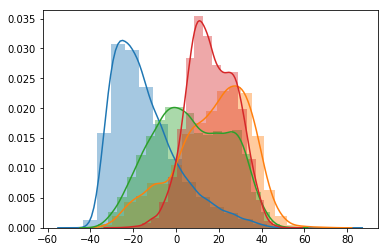

In [24]:
import seaborn as sns
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true=valid_data.Y.squeeze(), y_score=np.array(valid_preds).squeeze()))
from matplotlib import pyplot as plt
#histogram the predictions
sns.distplot(valid_preds[valid_data.Y.squeeze()==0],bins=20)
#sns.distplot(valid_preds[valid_data.Y.squeeze()==1],bins=20)
sns.distplot(unseen_positives_preds,bins=20)
sns.distplot(dinuc_shuff_positives_preds,bins=20)
sns.distplot(random_shuff_positives_preds,bins=20)
plt.show()

In [ ]:
#save space by deleting the validation data
#del valid_data
#del valid_preds